In [2]:
# ---- S0: Setup ----
BASE_DIR  = r"E:\AIML"
DATA_PATH = rf"{BASE_DIR}\dataset\heart_attack_prediction_dataset.csv"
EDA_DIR   = rf"{BASE_DIR}\results\eda_visualizations"
OUT_DIR   = rf"{BASE_DIR}\results\outputs"

import os, json, numpy as np, pandas as pd, matplotlib.pyplot as plt, warnings
from IPython.display import display

from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, RobustScaler
from sklearn.feature_selection import mutual_info_classif
from sklearn.decomposition import PCA

try:
    from imblearn.over_sampling import SMOTE
except Exception as e:
    raise ImportError("imblearn is required for SMOTE. Install via: pip install imbalanced-learn") from e

warnings.filterwarnings("ignore")
os.makedirs(EDA_DIR, exist_ok=True)
os.makedirs(OUT_DIR, exist_ok=True)

# Config
TARGET = "Heart Attack Risk"      
RANDOM_STATE = 42
USE_ROBUST_SCALER = True          
LOW_CARD_AS_CAT = 12              
CONT_UNIQUE_THRESH = 10           
TOP_K_MI = 15                     
APPLY_SMOTE = True                


Loaded shape: (8763, 26)


,Patient ID,Age,Sex,Cholesterol,Blood Pressure,Heart Rate,Diabetes,Family History,Smoking,Obesity,...,Sedentary Hours Per Day,Income,BMI,Triglycerides,Physical Activity Days Per Week,Sleep Hours Per Day,Country,Continent,Hemisphere,Heart Attack Risk
0,BMW7812,67,Male,208,158/88,72,0,0,1,0,...,6.615001,261404,31.251233,286,0,6,Argentina,South America,Southern Hemisphere,0
1,CZE1114,21,Male,389,165/93,98,1,1,1,1,...,4.963459,285768,27.194973,235,1,7,Canada,North America,Northern Hemisphere,0
2,BNI9906,21,Female,324,174/99,72,1,0,0,0,...,9.463426,235282,28.176571,587,4,4,France,Europe,Northern Hemisphere,0


Dropping ID-like columns: ['Patient ID']


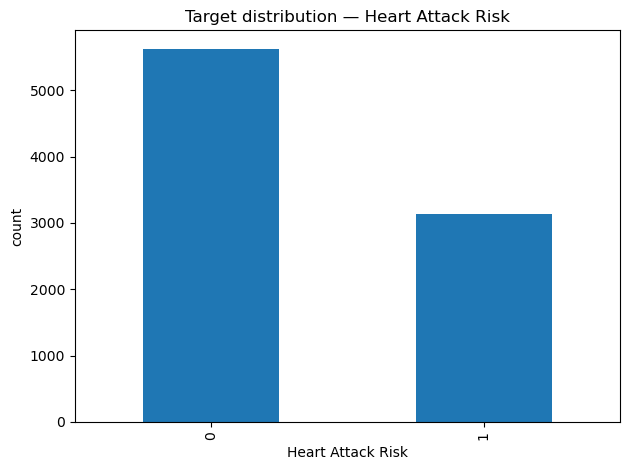

In [3]:
# ---- S1: Load & target overview ----
df = pd.read_csv(DATA_PATH)
print("Loaded shape:", df.shape)
display(df.head(3))

assert TARGET in df.columns, f"TARGET '{TARGET}' not found. Columns: {list(df.columns)}"

# Optional: drop exact duplicates
dups = df.duplicated().sum()
if dups:
    df = df.drop_duplicates().reset_index(drop=True)
    print(f"Dropped duplicates: {dups} | New shape: {df.shape}")

# Drop obvious ID-like columns from FEATURES (not used for modeling)
ID_COLS = [c for c in df.columns if c.strip().lower() in {"patient id","id","record id"}]
if ID_COLS:
    print("Dropping ID-like columns:", ID_COLS)
    df = df.drop(columns=ID_COLS)

# Target distribution (intro plot)
plt.figure()
df[TARGET].value_counts().sort_index().plot(kind="bar")
plt.title(f"Target distribution — {TARGET}")
plt.xlabel(TARGET); plt.ylabel("count")
plt.tight_layout(); plt.savefig(os.path.join(EDA_DIR, "target_distribution.png")); plt.show()

In [4]:
# ---- S2: Train/Test split ----
X = df.drop(columns=[TARGET]).copy()
y = df[TARGET].values
strat = y if pd.Series(y).nunique() <= 20 else None

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=strat
)
print("Split -> Train:", X_train.shape, " Test:", X_test.shape)


Split -> Train: (7010, 24)  Test: (1753, 24)


In [5]:
# ---- A1: Column typing for imputation ----
categorical_cols = []
for c in X_train.columns:
    if X_train[c].dtype == "object":
        categorical_cols.append(c)
    else:
        if X_train[c].nunique(dropna=True) <= LOW_CARD_AS_CAT:
            categorical_cols.append(c)
numeric_cols = [c for c in X_train.select_dtypes(include="number").columns if c not in categorical_cols]
print("[A] Categorical:", categorical_cols)
print("[A] Numeric:", numeric_cols)
#%%


[A] Categorical: ['Sex', 'Blood Pressure', 'Diabetes', 'Family History', 'Smoking', 'Obesity', 'Alcohol Consumption', 'Diet', 'Previous Heart Problems', 'Medication Use', 'Stress Level', 'Physical Activity Days Per Week', 'Sleep Hours Per Day', 'Country', 'Continent', 'Hemisphere']
[A] Numeric: ['Age', 'Cholesterol', 'Heart Rate', 'Exercise Hours Per Week', 'Sedentary Hours Per Day', 'Income', 'BMI', 'Triglycerides']


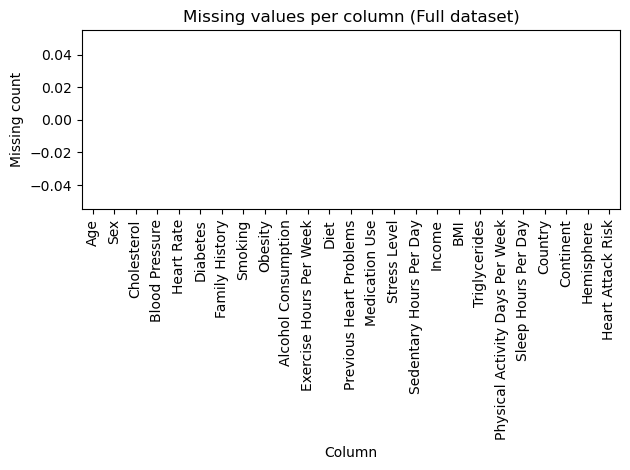

[A] After imputation -> TRAIN: (7010, 24)  TEST: (1753, 24)
[A] Remaining NaNs (TRAIN, TEST): 0 0


In [6]:
# ---- A2: Missingness visualization + Imputation ----
# Missingness (full dataset)
na_counts_full = df.isna().sum().sort_values(ascending=False)
plt.figure()
(na_counts_full[na_counts_full > 0] if na_counts_full.max() > 0 else na_counts_full).plot(kind="bar")
plt.title("Missing values per column (Full dataset)")
plt.xlabel("Column"); plt.ylabel("Missing count")
plt.tight_layout(); plt.savefig(os.path.join(EDA_DIR, "missing_values_full.png")); plt.show()

# Fit imputers on TRAIN; transform TRAIN/TEST
num_imputer = SimpleImputer(strategy="median")
cat_imputer = SimpleImputer(strategy="most_frequent")

X_train_num = num_imputer.fit_transform(X_train[numeric_cols]) if numeric_cols else None
X_test_num  = num_imputer.transform(X_test[numeric_cols])      if numeric_cols else None
X_train_cat = cat_imputer.fit_transform(X_train[categorical_cols]) if categorical_cols else None
X_test_cat  = cat_imputer.transform(X_test[categorical_cols])      if categorical_cols else None

# Reassemble DataFrames
tr_parts, te_parts = [], []
if X_train_num is not None:
    tr_parts.append(pd.DataFrame(X_train_num, columns=numeric_cols, index=X_train.index))
    te_parts.append(pd.DataFrame(X_test_num,  columns=numeric_cols, index=X_test.index))
if X_train_cat is not None:
    tr_parts.append(pd.DataFrame(X_train_cat, columns=categorical_cols, index=X_train.index))
    te_parts.append(pd.DataFrame(X_test_cat,  columns=categorical_cols, index=X_test.index))

X_train_imp = pd.concat(tr_parts, axis=1) if tr_parts else pd.DataFrame(index=X_train.index)
X_test_imp  = pd.concat(te_parts, axis=1) if te_parts else pd.DataFrame(index=X_test.index)

print("[A] After imputation -> TRAIN:", X_train_imp.shape, " TEST:", X_test_imp.shape)
print("[A] Remaining NaNs (TRAIN, TEST):",
      int(X_train_imp.isna().sum().sum()), int(X_test_imp.isna().sum().sum()))

# Save imputed splits
pd.concat([X_train_imp, pd.Series(y_train, index=X_train_imp.index, name=TARGET)], axis=1)\
  .to_csv(os.path.join(OUT_DIR, "X_train_imputed.csv"), index=False)
pd.concat([X_test_imp,  pd.Series(y_test,  index=X_test_imp.index,  name=TARGET)], axis=1)\
  .to_csv(os.path.join(OUT_DIR, "X_test_imputed.csv"),  index=False)

In [7]:
# ---- C1: Choose continuous numeric columns (IQR) ----
cont_cols = [c for c in numeric_cols if c in X_train_imp.columns and X_train_imp[c].nunique() > CONT_UNIQUE_THRESH]
print("[C] Continuous numeric columns:", cont_cols)
#%%


[C] Continuous numeric columns: ['Age', 'Cholesterol', 'Heart Rate', 'Exercise Hours Per Week', 'Sedentary Hours Per Day', 'Income', 'BMI', 'Triglycerides']


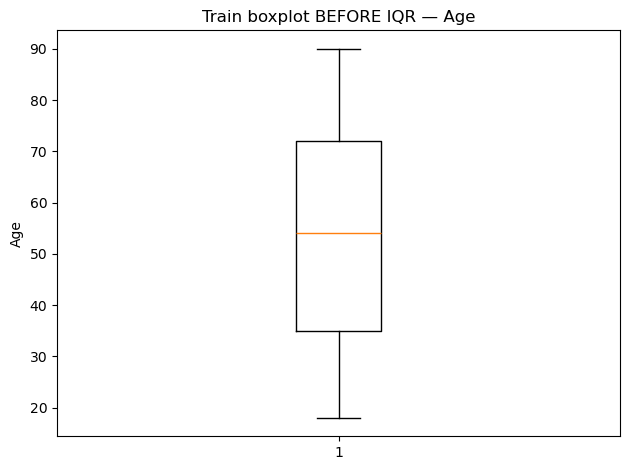

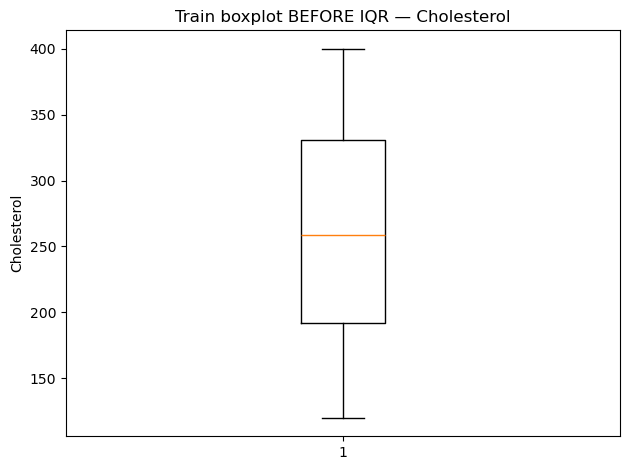

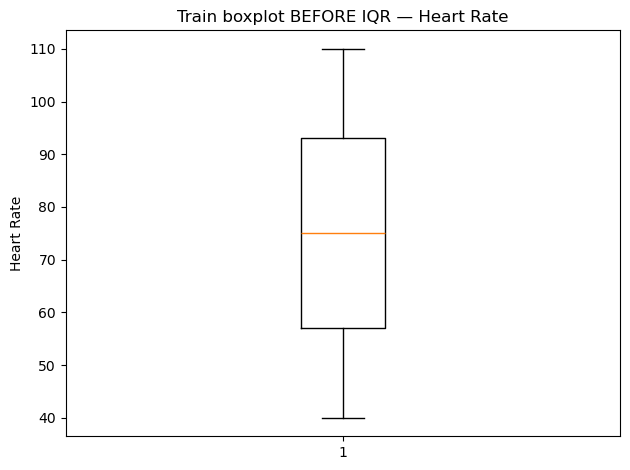

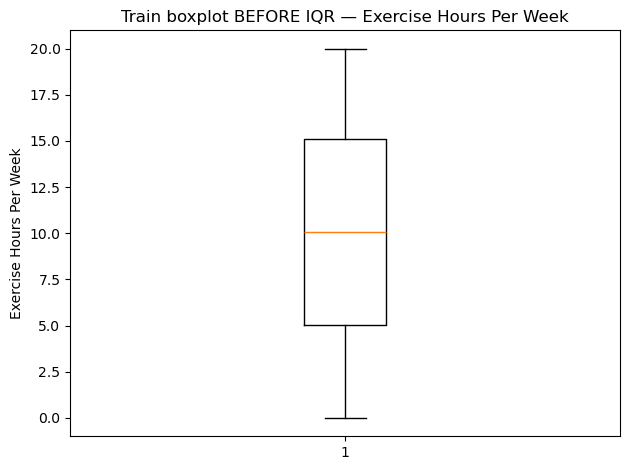

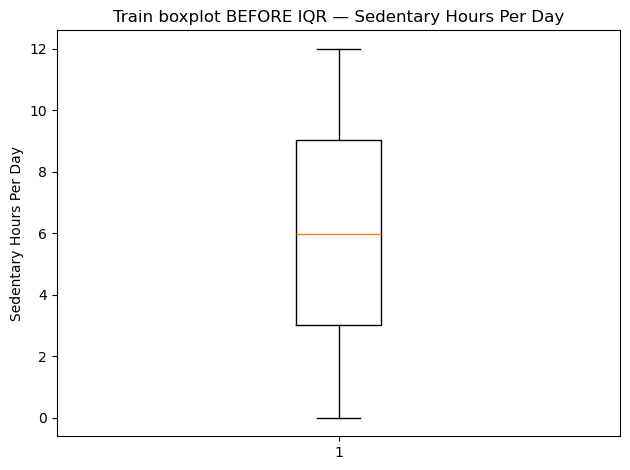

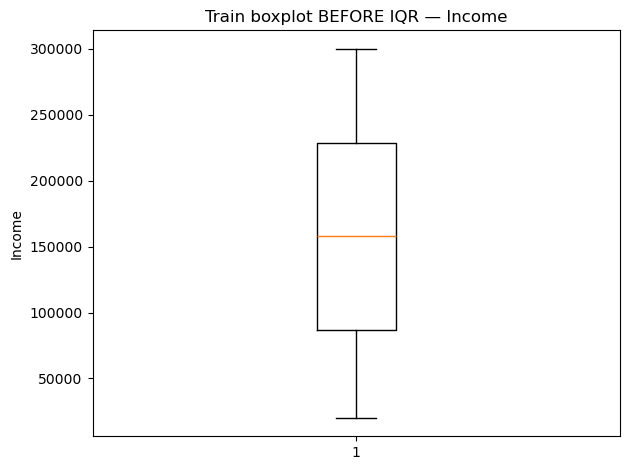

[C] IQR kept 7010/7010 rows (removed 0).


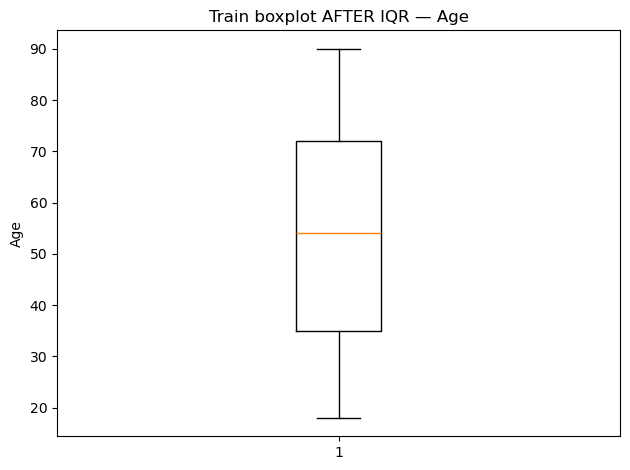

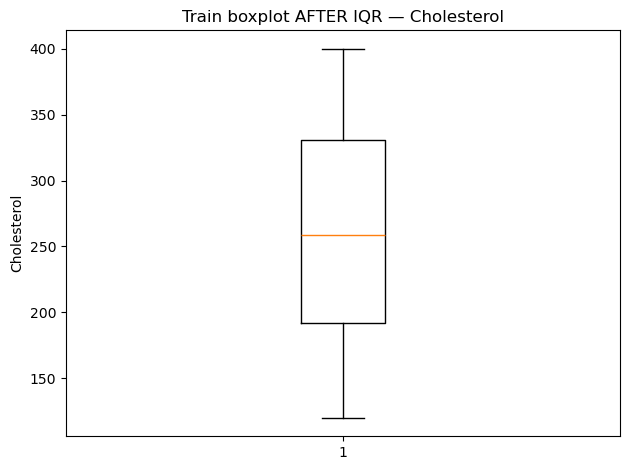

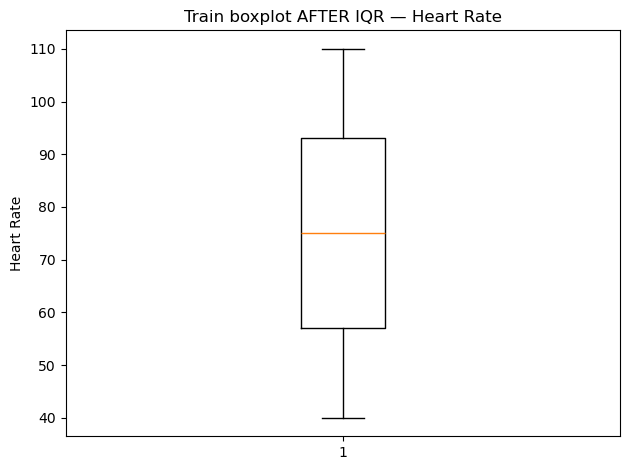

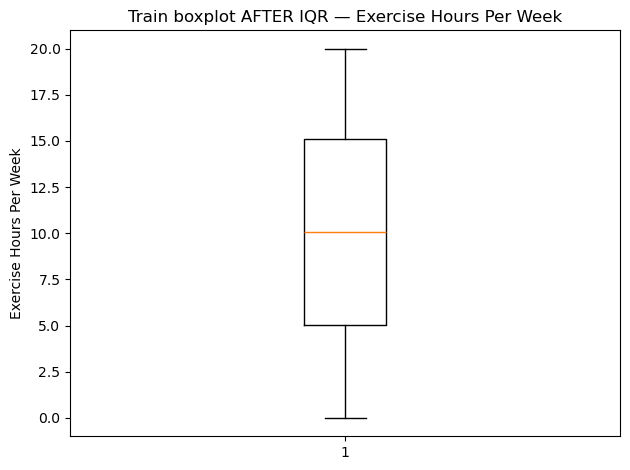

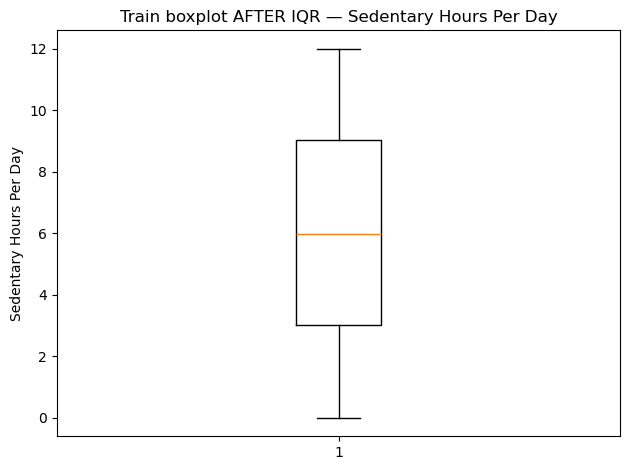

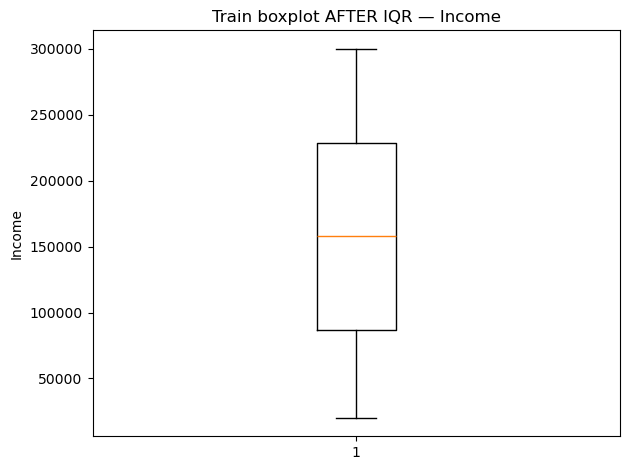

In [8]:
# ---- C2: Boxplots BEFORE + IQR filter (TRAIN only) ----
# BEFORE
for c in cont_cols[:6]:
    plt.figure(); plt.boxplot(X_train_imp[c].dropna())
    plt.title(f"Train boxplot BEFORE IQR — {c}")
    plt.ylabel(c); plt.tight_layout(); plt.savefig(os.path.join(EDA_DIR, f"box_before_{c}.png")); plt.show()

def iqr_mask(df_cont: pd.DataFrame) -> pd.Series:
    m = pd.Series(True, index=df_cont.index)
    for col in df_cont.columns:
        Q1, Q3 = df_cont[col].quantile(0.25), df_cont[col].quantile(0.75)
        IQR = Q3 - Q1
        lower, upper = Q1 - 1.5*IQR, Q3 + 1.5*IQR
        m &= (df_cont[col] >= lower) & (df_cont[col] <= upper)
    return m

use_iqr = True
if use_iqr and cont_cols:
    mask = iqr_mask(X_train_imp[cont_cols])
    kept = int(mask.sum()); total = len(mask)
    print(f"[C] IQR kept {kept}/{total} rows (removed {total-kept}).")
    X_train_iqr = X_train_imp.loc[mask].copy()
    y_train_iqr = pd.Series(y_train, index=X_train_imp.index).loc[mask].values
else:
    print("[C] Skipping IQR removal (will rely on robust scaling).")
    X_train_iqr = X_train_imp.copy()
    y_train_iqr = y_train

# AFTER
for c in cont_cols[:6]:
    plt.figure(); plt.boxplot(X_train_iqr[c].dropna())
    plt.title(f"Train boxplot AFTER IQR — {c}")
    plt.ylabel(c); plt.tight_layout(); plt.savefig(os.path.join(EDA_DIR, f"box_after_{c}.png")); plt.show()

# Save IQR-filtered train
pd.concat([X_train_iqr, pd.Series(y_train_iqr, index=X_train_iqr.index, name=TARGET)], axis=1)\
  .to_csv(os.path.join(OUT_DIR, "X_train_imputed_iqr.csv"), index=False)

[B] After encoding -> TRAIN: (7010, 3685)  TEST: (1753, 3685)


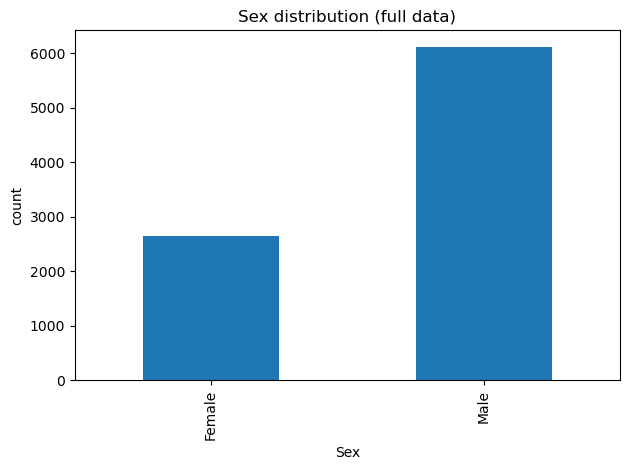

In [9]:
# ---- B1: One-Hot Encoding (TRAIN fit) ----
try:
    ohe = OneHotEncoder(handle_unknown="ignore", sparse_output=False)  # sklearn >=1.2
except TypeError:
    ohe = OneHotEncoder(handle_unknown="ignore", sparse=False)         # older sklearn

if categorical_cols:
    Xtr_cat = X_train_iqr[categorical_cols].astype("category")
    Xte_cat = X_test_imp[categorical_cols].astype("category")
    Xtr_ohe = ohe.fit_transform(Xtr_cat)
    Xte_ohe = ohe.transform(Xte_cat)
    try:
        ohe_cols = list(ohe.get_feature_names_out(categorical_cols))
    except AttributeError:
        ohe_cols = [f"{c}_{v}" for c, cats in zip(categorical_cols, ohe.categories_) for v in cats]
    df_tr_ohe = pd.DataFrame(Xtr_ohe, columns=ohe_cols, index=X_train_iqr.index)
    df_te_ohe = pd.DataFrame(Xte_ohe, columns=ohe_cols, index=X_test_imp.index)
else:
    df_tr_ohe = pd.DataFrame(index=X_train_iqr.index)
    df_te_ohe = pd.DataFrame(index=X_test_imp.index)

num_keep_cols = [c for c in X_train_iqr.columns if c in numeric_cols]
X_train_enc = pd.concat([X_train_iqr[num_keep_cols], df_tr_ohe], axis=1)
X_test_enc  = pd.concat([X_test_imp[num_keep_cols],  df_te_ohe],  axis=1)
print("[B] After encoding -> TRAIN:", X_train_enc.shape, " TEST:", X_test_enc.shape)

# cp distribution (or fallback categorical)
plot_col = "cp" if ("cp" in categorical_cols and "cp" in df.columns) else (categorical_cols[0] if categorical_cols else None)
if plot_col:
    plt.figure()
    df[plot_col].value_counts(dropna=False).sort_index().plot(kind="bar")
    plt.title(f"{plot_col} distribution (full data)")
    plt.xlabel(plot_col); plt.ylabel("count")
    plt.tight_layout(); plt.savefig(os.path.join(EDA_DIR, f"{plot_col}_distribution.png")); plt.show()

# Save encoded splits
pd.concat([X_train_enc, pd.Series(y_train_iqr, index=X_train_enc.index, name=TARGET)], axis=1)\
  .to_csv(os.path.join(OUT_DIR, "X_train_encoded.csv"), index=False)
pd.concat([X_test_enc,  pd.Series(y_test,     index=X_test_enc.index,  name=TARGET)], axis=1)\
  .to_csv(os.path.join(OUT_DIR, "X_test_encoded.csv"),  index=False)

[D] After scaling -> TRAIN: (7010, 3685)  TEST: (1753, 3685)


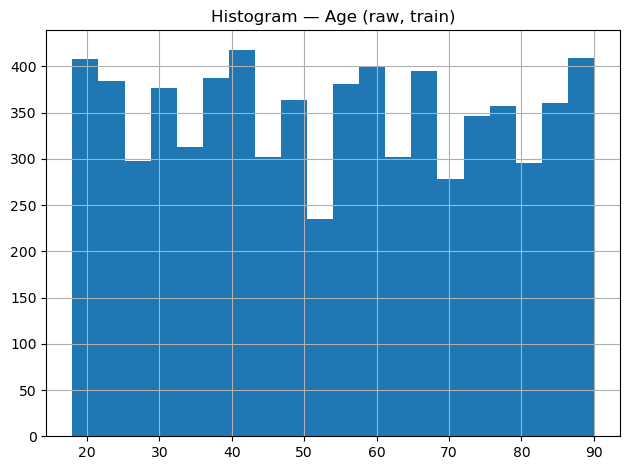

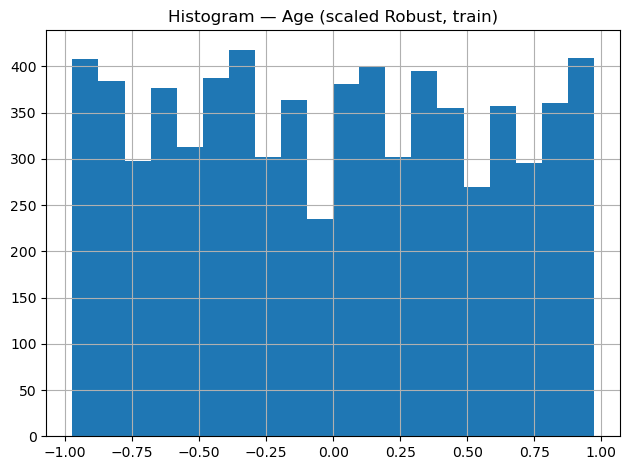

In [10]:
# ---- D1: Feature Scaling (numeric only) ----
scaler = RobustScaler() if USE_ROBUST_SCALER else StandardScaler()

num_cols_for_scaling = [c for c in X_train_enc.columns if c in num_keep_cols]
Xtr_num = X_train_enc[num_cols_for_scaling].values if num_cols_for_scaling else np.empty((len(X_train_enc), 0))
Xte_num = X_test_enc[num_cols_for_scaling].values  if num_cols_for_scaling else np.empty((len(X_test_enc),  0))

if Xtr_num.shape[1] > 0:
    Xtr_num_s = scaler.fit_transform(Xtr_num)   # fit on TRAIN
    Xte_num_s = scaler.transform(Xte_num)       # transform TEST
else:
    Xtr_num_s = Xtr_num; Xte_num_s = Xte_num

df_tr_num_s = pd.DataFrame(Xtr_num_s, columns=num_cols_for_scaling, index=X_train_enc.index)
df_te_num_s = pd.DataFrame(Xte_num_s, columns=num_cols_for_scaling, index=X_test_enc.index)

# Recombine scaled numerics + OHE
non_scaled_cols = [c for c in X_train_enc.columns if c not in num_cols_for_scaling]
X_train_scaled = pd.concat([df_tr_num_s, X_train_enc[non_scaled_cols]], axis=1)
X_test_scaled  = pd.concat([df_te_num_s,  X_test_enc[non_scaled_cols]],  axis=1)
X_train_scaled = X_train_scaled[num_cols_for_scaling + non_scaled_cols]
X_test_scaled  = X_test_scaled[num_cols_for_scaling + non_scaled_cols]

print("[D] After scaling -> TRAIN:", X_train_scaled.shape, " TEST:", X_test_scaled.shape)

# Histogram before vs after (demo numeric)
if num_cols_for_scaling:
    demo_col = num_cols_for_scaling[0]
    plt.figure(); X_train_enc[demo_col].dropna().hist(bins=20)
    plt.title(f"Histogram — {demo_col} (raw, train)")
    plt.tight_layout(); plt.savefig(os.path.join(EDA_DIR, f"hist_raw_{demo_col}.png")); plt.show()

    plt.figure(); df_tr_num_s[demo_col].dropna().hist(bins=20)
    plt.title(f"Histogram — {demo_col} (scaled {'Robust' if USE_ROBUST_SCALER else 'Standard'}, train)")
    plt.tight_layout(); plt.savefig(os.path.join(EDA_DIR, f"hist_scaled_{demo_col}.png")); plt.show()

# Save scaled splits
pd.concat([X_train_scaled, pd.Series(y_train_iqr, index=X_train_scaled.index, name=TARGET)], axis=1)\
  .to_csv(os.path.join(OUT_DIR, "X_train_scaled.csv"), index=False)
pd.concat([X_test_scaled,  pd.Series(y_test,     index=X_test_scaled.index,  name=TARGET)], axis=1)\
  .to_csv(os.path.join(OUT_DIR, "X_test_scaled.csv"),  index=False)

In [17]:
# ---- E1: Numeric-only matrix for MI/PCA ----
Xtr_num_all = X_train_scaled.select_dtypes(include="number").copy()
Xte_num_all = X_test_scaled.select_dtypes(include="number").copy()
y_train_FE  = y_train_iqr  # aligned with X_train_iqr lineage
print("[E] Numeric-only -> TRAIN:", Xtr_num_all.shape, " TEST:", Xte_num_all.shape)

[E] Numeric-only -> TRAIN: (7010, 3685)  TEST: (1753, 3685)


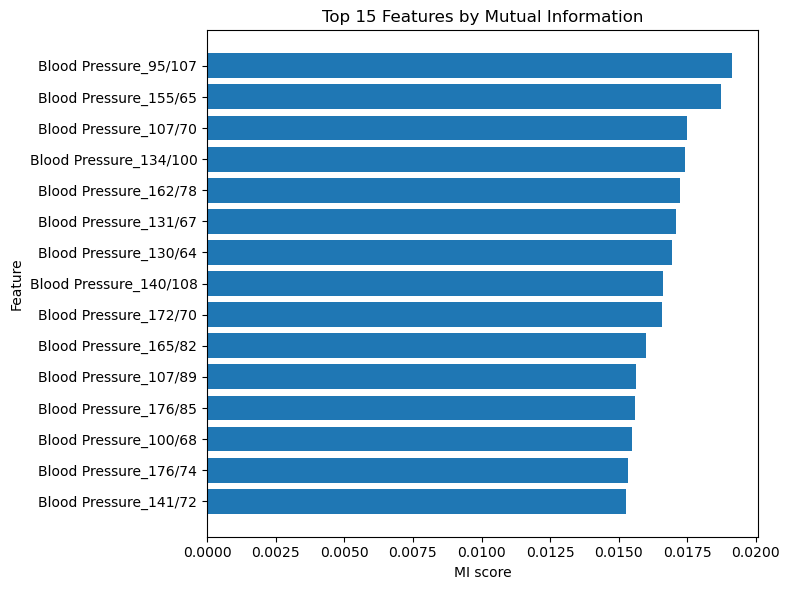

[E] MI-selected -> TRAIN: (7010, 15)  TEST: (1753, 15)


In [18]:
# ---- E2: Mutual Information ----
mi_scores = mutual_info_classif(Xtr_num_all.values, y_train_FE, discrete_features=False, random_state=RANDOM_STATE)
mi_df = pd.DataFrame({"feature": Xtr_num_all.columns, "mi": mi_scores}).sort_values("mi", ascending=False)

k = min(TOP_K_MI, len(mi_df))
topk = mi_df.head(k).iloc[::-1]

plt.figure(figsize=(8,6))
plt.barh(topk["feature"], topk["mi"])
plt.title(f"Top {k} Features by Mutual Information")
plt.xlabel("MI score"); plt.ylabel("Feature")
plt.tight_layout(); plt.savefig(os.path.join(EDA_DIR, f"mi_top_{k}.png")); plt.show()

mi_df.to_csv(os.path.join(OUT_DIR, "feature_importance_MI.csv"), index=False)

# Optional: Top-k MI reduced sets
X_train_mi = Xtr_num_all[mi_df.head(k)["feature"].tolist()].copy()
X_test_mi  = Xte_num_all[mi_df.head(k)["feature"].tolist()].copy()
X_train_mi.to_csv(os.path.join(OUT_DIR, f"X_train_top{k}_MI.csv"), index=False)
X_test_mi.to_csv(os.path.join(OUT_DIR,  f"X_test_top{k}_MI.csv"),  index=False)
print("[E] MI-selected -> TRAIN:", X_train_mi.shape, " TEST:", X_test_mi.shape)

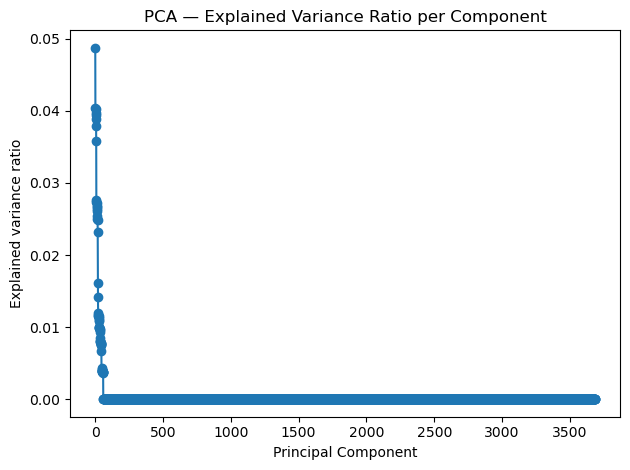

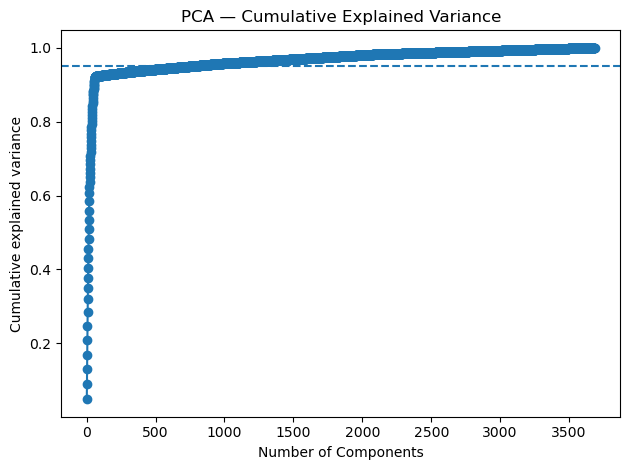

[E] ~95% variance with 751 PCs.
[E] PCA shapes -> TRAIN: (7010, 751)  TEST: (1753, 751)


In [19]:
# ---- E3: PCA (fit on TRAIN) + plots + transform ----
pca = PCA(n_components=None, random_state=RANDOM_STATE).fit(Xtr_num_all.values)
exp = pca.explained_variance_ratio_
cum = np.cumsum(exp)

plt.figure(); plt.plot(range(1, len(exp)+1), exp, marker="o")
plt.title("PCA — Explained Variance Ratio per Component")
plt.xlabel("Principal Component"); plt.ylabel("Explained variance ratio")
plt.tight_layout(); plt.savefig(os.path.join(EDA_DIR, "pca_explained_variance.png")); plt.show()

plt.figure(); plt.plot(range(1, len(cum)+1), cum, marker="o"); plt.axhline(0.95, linestyle="--")
plt.title("PCA — Cumulative Explained Variance")
plt.xlabel("Number of Components"); plt.ylabel("Cumulative explained variance")
plt.tight_layout(); plt.savefig(os.path.join(EDA_DIR, "pca_cumulative_variance.png")); plt.show()

n95 = int(np.argmax(cum >= 0.95) + 1)
print(f"[E] ~95% variance with {n95} PCs.")

pca95 = PCA(n_components=n95, random_state=RANDOM_STATE).fit(Xtr_num_all.values)
X_train_pca = pca95.transform(Xtr_num_all.values)
X_test_pca  = pca95.transform(Xte_num_all.values)

pd.DataFrame(X_train_pca, columns=[f"PC{i}" for i in range(1, n95+1)])\
  .to_csv(os.path.join(OUT_DIR, f"X_train_PCA_{n95}.csv"), index=False)
pd.DataFrame(X_test_pca,  columns=[f"PC{i}" for i in range(1, n95+1)])\
  .to_csv(os.path.join(OUT_DIR,  f"X_test_PCA_{n95}.csv"),  index=False)

print("[E] PCA shapes -> TRAIN:", X_train_pca.shape, " TEST:", X_test_pca.shape)

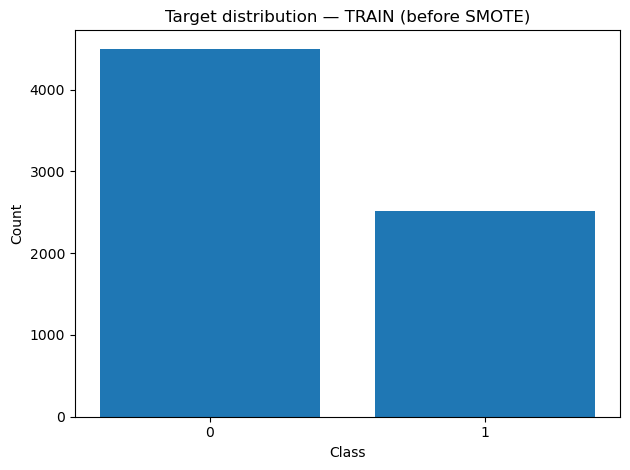

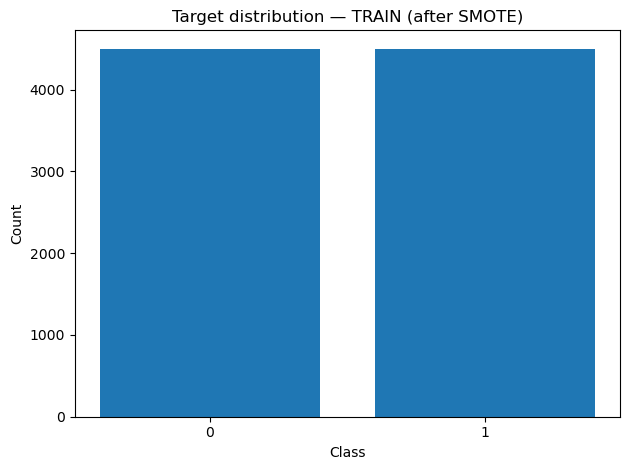

[F] SMOTE applied (k=5). TRAIN (resampled): (8998, 3685)  | TEST unchanged: (1753, 3685)


In [20]:
# ---- F1: SMOTE (TRAIN only) ----
from collections import Counter

if APPLY_SMOTE:
    X_for_smote = Xtr_num_all.copy()
    y_for_smote = y_train_iqr

    # BEFORE
    counts_before = Counter(y_for_smote)
    plt.figure(); plt.bar([str(k) for k in sorted(counts_before)], [counts_before[k] for k in sorted(counts_before)])
    plt.title("Target distribution — TRAIN (before SMOTE)"); plt.xlabel("Class"); plt.ylabel("Count")
    plt.tight_layout(); plt.savefig(os.path.join(EDA_DIR, "target_train_before_smote.png")); plt.show()

    min_count = min(counts_before.values())
    k_neighbors = max(1, min(5, min_count - 1))
    smote = SMOTE(random_state=RANDOM_STATE, k_neighbors=k_neighbors)

    X_train_res, y_train_res = smote.fit_resample(X_for_smote.values, y_for_smote)
    X_train_res = pd.DataFrame(X_train_res, columns=X_for_smote.columns)

    # AFTER
    counts_after = Counter(y_train_res)
    plt.figure(); plt.bar([str(k) for k in sorted(counts_after)], [counts_after[k] for k in sorted(counts_after)])
    plt.title("Target distribution — TRAIN (after SMOTE)"); plt.xlabel("Class"); plt.ylabel("Count")
    plt.tight_layout(); plt.savefig(os.path.join(EDA_DIR, "target_train_after_smote.png")); plt.show()

    # Save resampled TRAIN
    X_train_res.to_csv(os.path.join(OUT_DIR, "X_train_FE_SMOTE.csv"), index=False)
    pd.Series(y_train_res, name=TARGET).to_csv(os.path.join(OUT_DIR, "y_train_FE_SMOTE.csv"), index=False)
    print(f"[F] SMOTE applied (k={k_neighbors}). TRAIN (resampled):", X_train_res.shape, " | TEST unchanged:", X_test_scaled.shape)
else:
    print("[F] SMOTE disabled; skipping resampling.")

In [21]:
# ---- Final: Save combined updated CSVs ----
# 1) Primary: Encoded + Scaled (train+test with split marker)
train_full = X_train_scaled.copy();  train_full[TARGET] = y_train_iqr;  train_full["split"] = "train"
test_full  = X_test_scaled.copy();   test_full[TARGET]  = y_test;       test_full["split"]  = "test"
processed_full_scaled = pd.concat([train_full, test_full], axis=0)
scaled_path = os.path.join(OUT_DIR, "processed_full_scaled.csv")
processed_full_scaled.to_csv(scaled_path, index=False)

# 2) Optional: Top-K MI (train+test)
if 'X_train_mi' in globals() and 'X_test_mi' in globals():
    train_mi = X_train_mi.copy();  train_mi[TARGET] = y_train_iqr;  train_mi["split"] = "train"
    test_mi  = X_test_mi.copy();   test_mi[TARGET]  = y_test;       test_mi["split"]  = "test"
    mi_path = os.path.join(OUT_DIR, f"processed_full_MI_top{TOP_K_MI}.csv")
    pd.concat([train_mi, test_mi], axis=0).to_csv(mi_path, index=False)
else:
    mi_path = None

# 3) Optional: PCA(n95) (train+test)
if 'X_train_pca' in globals() and 'X_test_pca' in globals():
    pc_cols = [f"PC{i}" for i in range(1, X_train_pca.shape[1]+1)]
    train_pca_df = pd.DataFrame(X_train_pca, columns=pc_cols, index=X_train_scaled.index)
    test_pca_df  = pd.DataFrame(X_test_pca,  columns=pc_cols, index=X_test_scaled.index)
    train_pca_df[TARGET] = y_train_iqr; train_pca_df["split"] = "train"
    test_pca_df[TARGET]  = y_test;      test_pca_df["split"]  = "test"
    pca_path = os.path.join(OUT_DIR, f"processed_full_PCA_{X_train_pca.shape[1]}.csv")
    pd.concat([train_pca_df, test_pca_df], axis=0).to_csv(pca_path, index=False)
else:
    pca_path = None

print("\n=== UPDATED CSVs SAVED ===")
print("1) Encoded + Scaled (primary):", scaled_path)
print("2) Top-K MI (optional):       ", mi_path)
print("3) PCA (optional):            ", pca_path)


=== UPDATED CSVs SAVED ===
1) Encoded + Scaled (primary): E:\AIML\results\outputs\processed_full_scaled.csv
2) Top-K MI (optional):        E:\AIML\results\outputs\processed_full_MI_top15.csv
3) PCA (optional):             E:\AIML\results\outputs\processed_full_PCA_751.csv
